Random Policyの実験において、分割して行った実験のマージを行う。

マージのために時間を一律基準で揃える

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
import shutil
import pandas as pd

BASE_DIR = "/home/lucvil/vguardbft/results/multi_rsu_congestion_random/vs70/n253/m32/d0"
CONS_FILE = "consensus_folder.csv"
ORDER_FILE = "ordering_event.csv"

V_PATTERN = re.compile(r"_v(-?\d+)")  # フォルダ名から v の数値を取得 (例: 0_v70 -> 70)

def extract_v_value(dirname: str) -> int:
    m = V_PATTERN.search(dirname)
    if not m:
        raise ValueError(f"フォルダ名から v の数値を取得できませんでした: {dirname}")
    return int(m.group(1))

def load_ordering_start0(order_path: str) -> int:
    # id=0 の start_time を取得
    df = pd.read_csv(order_path, dtype=str)
    # id列は文字列として読み、"0" の行を探す。なければ最初の行を使うフォールバック。
    if "id" not in df.columns or "start_time" not in df.columns:
        raise ValueError(f"{order_path} に id / start_time 列が存在しません。")
    row = df[df["id"] == "0"]
    if row.empty:
        row = df.iloc[:1]
    t0_str = row["start_time"].iloc[0]
    if pd.isna(t0_str) or t0_str == "null":
        raise ValueError(f"{order_path} の id=0 の start_time が無効です。")
    return int(t0_str)

def transform_series(s: pd.Series, t0: int, offset_ms: int) -> pd.Series:
    # "null" や NaN はそのまま残す。数値のみ変換。
    numeric = pd.to_numeric(s, errors="coerce")
    transformed = numeric - t0 + offset_ms
    # 整数に丸め、NaN はそのまま NaN のまま（to_csv 時に na_rep='null' で出力）
    return transformed.round().astype("Int64")

def process_folder(folder_path: str):
    folder_name = os.path.basename(folder_path.rstrip(os.sep))
    v_value = extract_v_value(folder_name)
    offset_ms = v_value * 1000

    order_path = os.path.join(folder_path, ORDER_FILE)
    cons_path  = os.path.join(folder_path, CONS_FILE)

    if not (os.path.isfile(order_path) and os.path.isfile(cons_path)):
        # どちらか無ければスキップ
        return

    t0 = load_ordering_start0(order_path)

    # consensus_folder.csv を読み込む
    df = pd.read_csv(cons_path, dtype=str)

    # 必要列が無ければスキップ
    for col in ["start_time", "end_time"]:
        if col not in df.columns:
            print(f"[WARN] {cons_path} に {col} 列がありません。スキップします。")
            return

    # バックアップ作成
    backup_path = cons_path + ".bak"
    if not os.path.exists(backup_path):
        shutil.copy2(cons_path, backup_path)

    # 変換
    df["start_time"] = transform_series(df["start_time"], t0, offset_ms)
    df["end_time"]   = transform_series(df["end_time"],   t0, offset_ms)

    # CSV に書き戻し（NaN は 'null' として出力）
    df.to_csv(cons_path, index=False, na_rep="null")
    print(f"[OK] 更新完了: {cons_path}  (v={v_value}, offset={offset_ms}ms, t0={t0})")

def main():
    # 直下のサブフォルダのみ処理（0_v0, 0_v70, ...）
    for name in sorted(os.listdir(BASE_DIR)):
        subdir = os.path.join(BASE_DIR, name)
        if os.path.isdir(subdir) and "_v" in name:
            try:
                process_folder(subdir)
            except Exception as e:
                print(f"[ERROR] {subdir}: {e}")

if __name__ == "__main__":
    main()


[OK] 更新完了: /home/lucvil/vguardbft/results/multi_rsu_congestion_random/vs70/n253/m32/d0/0_v0/consensus_folder.csv  (v=0, offset=0ms, t0=1756846108061)
[OK] 更新完了: /home/lucvil/vguardbft/results/multi_rsu_congestion_random/vs70/n253/m32/d0/0_v140/consensus_folder.csv  (v=140, offset=140000ms, t0=1756848279173)
[OK] 更新完了: /home/lucvil/vguardbft/results/multi_rsu_congestion_random/vs70/n253/m32/d0/0_v210/consensus_folder.csv  (v=210, offset=210000ms, t0=1756849824577)
[OK] 更新完了: /home/lucvil/vguardbft/results/multi_rsu_congestion_random/vs70/n253/m32/d0/0_v270/consensus_folder.csv  (v=270, offset=270000ms, t0=1756851600484)
[OK] 更新完了: /home/lucvil/vguardbft/results/multi_rsu_congestion_random/vs70/n253/m32/d0/0_v340/consensus_folder.csv  (v=340, offset=340000ms, t0=1756852709921)
[OK] 更新完了: /home/lucvil/vguardbft/results/multi_rsu_congestion_random/vs70/n253/m32/d0/0_v70/consensus_folder.csv  (v=70, offset=70000ms, t0=1756847159361)
[OK] 更新完了: /home/lucvil/vguardbft/results/multi_rsu_conges

時間を揃えたあとにマージ

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
import shutil
import pandas as pd

# ---- 設定 ----
BASE_DIR = "/home/lucvil/vguardbft/results/multi_rsu_congestion_random/vs70/n253/m32/d0"
CONS_FILE = "consensus_folder.csv"
DIR_RE = re.compile(r"^(\d+)_v(-?\d+)$")   # "<group>_v<val>" 例) "0_v70"

# ---- ユーティリティ ----
def find_groups(base_dir: str):
    """
    base_dir 直下の "<group>_v<val>" 形式のサブフォルダを収集。
    戻り値: { group:int -> [(v:int, folder_path:str), ...] } （v昇順）
    """
    groups = {}
    for name in os.listdir(base_dir):
        m = DIR_RE.match(name)
        if not m:
            continue
        g = int(m.group(1))
        v = int(m.group(2))
        path = os.path.join(base_dir, name)
        if os.path.isdir(path):
            groups.setdefault(g, []).append((v, path))
    for g in groups:
        groups[g].sort(key=lambda x: x[0])  # v昇順
    return groups

def load_consensus(path: str) -> pd.DataFrame | None:
    """
    該当フォルダの consensus_folder.csv を dtype=str で読み込む。
    無ければ None。
    """
    csv_path = os.path.join(path, CONS_FILE)
    if not os.path.isfile(csv_path):
        return None
    return pd.read_csv(csv_path, dtype=str)

def filter_by_window(df: pd.DataFrame, lower_ms: int, upper_ms: int | None) -> pd.DataFrame:
    """
    start_time を数値化し、[lower_ms, upper_ms) に入る行だけを返す。
    upper_ms=None の場合は [lower_ms, ∞)。
    数値化できない start_time（NaN, 'null' など）は除外。
    """
    if "start_time" not in df.columns:
        return pd.DataFrame(columns=df.columns)

    st = df["start_time"].replace("null", pd.NA)
    st_num = pd.to_numeric(st, errors="coerce")

    if upper_ms is None:
        mask = st_num >= lower_ms
    else:
        mask = (st_num >= lower_ms) & (st_num < upper_ms)

    return df[mask.fillna(False)].copy()

def reorder_and_reindex(df: pd.DataFrame) -> pd.DataFrame:
    """
    id を 0..N-1 で振り直し、列順を整える。
    """
    df = df.reset_index(drop=True)
    df["id"] = range(len(df))
    priority = ["id", "start_time", "end_time", "duration", "len_block_range", "booth"]
    cols = [c for c in priority if c in df.columns] + [c for c in df.columns if c not in priority]
    return df[cols]

def backup_if_exists(path: str):
    """
    既存ファイルがあれば .bak を作る（上書きはしない）。
    """
    if os.path.exists(path):
        bak = path + ".bak"
        if not os.path.exists(bak):
            shutil.copy2(path, bak)

# ---- メイン処理 ----
def merge_group_to_folder(group_id: int, items: list[tuple[int, str]], base_dir: str):
    """
    1グループ（例: group_id=0 で 0_v0, 0_v70, ...）内の consensus_folder.csv を
    v 値ごとの時間窓で抽出し結合。結果を BASE_DIR/<group_id>/consensus_folder.csv に保存。
    """
    parts = []
    for i, (v, path) in enumerate(items):
        lower = v * 1000
        upper = items[i + 1][0] * 1000 if i + 1 < len(items) else None

        df = load_consensus(path)
        if df is None:
            print(f"[WARN] consensus not found: {path}")
            continue

        part = filter_by_window(df, lower_ms=lower, upper_ms=upper)
        parts.append(part)

        rng_txt = f"[{lower}, {upper})" if upper is not None else f"[{lower}, ∞)"
        print(f"[INFO] group={group_id}, v={v}, range={rng_txt}, rows={len(part)}")

    if not parts:
        print(f"[WARN] group={group_id}: no rows collected.")
        return

    merged = pd.concat(parts, ignore_index=True)

    # start_time昇順で並べ替え（数値化できるものだけ基準に）
    if "start_time" in merged.columns:
        merged["_st_num"] = pd.to_numeric(merged["start_time"].replace("null", pd.NA), errors="coerce")
        merged = merged.sort_values(by=["_st_num"], kind="stable").drop(columns=["_st_num"]).reset_index(drop=True)

    merged = reorder_and_reindex(merged)

    # 出力先フォルダを BASE_DIR/<group_id> に作る
    out_dir = os.path.join(base_dir, str(group_id))
    os.makedirs(out_dir, exist_ok=True)
    out_csv = os.path.join(out_dir, CONS_FILE)

    # 既存があれば .bak 退避
    backup_if_exists(out_csv)

    # 保存（NaN は 'null' として出力）
    merged.to_csv(out_csv, index=False, na_rep="null")
    print(f"[OK] saved: {out_csv} (rows={len(merged)})")

def main():
    groups = find_groups(BASE_DIR)
    if not groups:
        print("[ERROR] no '<group>_v*' folders found.")
        return

    # group 昇順に処理（例: 0, 1, 2, ...）
    for g, items in sorted(groups.items(), key=lambda kv: kv[0]):
        merge_group_to_folder(g, items, BASE_DIR)

if __name__ == "__main__":
    main()


[INFO] group=0, v=0, range=[0, 70000), rows=3
[INFO] group=0, v=70, range=[70000, 140000), rows=12
[INFO] group=0, v=140, range=[140000, 210000), rows=0
[INFO] group=0, v=210, range=[210000, 270000), rows=5
[INFO] group=0, v=270, range=[270000, 340000), rows=4
[INFO] group=0, v=340, range=[340000, ∞), rows=0
[OK] saved: /home/lucvil/vguardbft/results/multi_rsu_congestion_random/vs70/n253/m32/d0/0/consensus_folder.csv (rows=24)
[INFO] group=1, v=0, range=[0, 70000), rows=0
[INFO] group=1, v=70, range=[70000, 140000), rows=68
[INFO] group=1, v=140, range=[140000, 210000), rows=40
[INFO] group=1, v=210, range=[210000, 270000), rows=0
[INFO] group=1, v=270, range=[270000, 340000), rows=65
[INFO] group=1, v=340, range=[340000, ∞), rows=45
[OK] saved: /home/lucvil/vguardbft/results/multi_rsu_congestion_random/vs70/n253/m32/d0/1/consensus_folder.csv (rows=218)
[INFO] group=2, v=0, range=[0, 70000), rows=3
[INFO] group=2, v=70, range=[70000, 140000), rows=6
[INFO] group=2, v=140, range=[140000

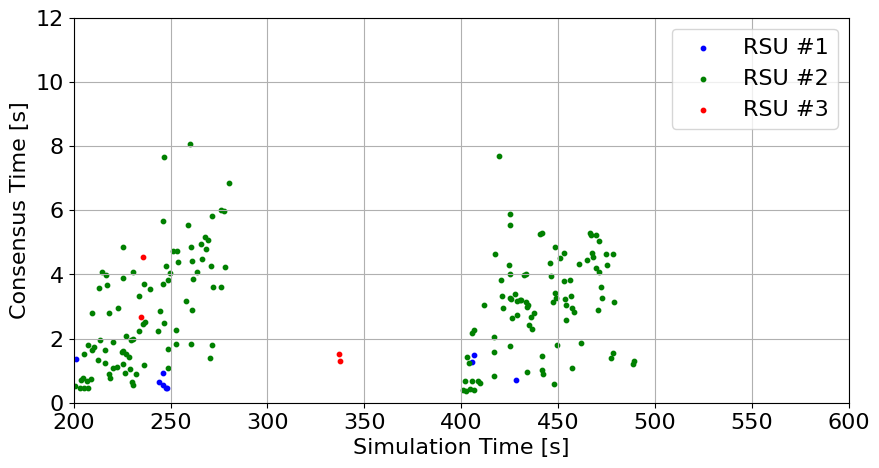

In [7]:
import pandas as pd
import ast
import matplotlib.pyplot as plt


def get_consensus_time(input_folder_path):

    # CSVファイルの読み込み
    proposer_df = pd.read_csv(input_folder_path + "consensus_folder.csv")
    proposer_df = proposer_df.replace('null', pd.NA)

    # 結果を格納するリスト
    result = []
    simulation_buffer_time = 200
    simulation_start_time = 0
    simulation_time_list = []
    simulation_consensus_time_list = []

    # idごとに処理を行う
    for index, row in proposer_df.iterrows():
        if index == 0:
            simulation_start_time = int(row["start_time"])

        if pd.isna(row["end_time"]) or pd.isna(row["duration"]):
            continue  # Skip rows with NaN values
        
        simulation_now_time = (int(row["end_time"]) - simulation_start_time) / 1000 + simulation_buffer_time

        simulation_time_list.append(simulation_now_time)
        simulation_consensus_time_list.append(int(row["duration"]) / 1000)
    
    return simulation_time_list, simulation_consensus_time_list



# vehicle_speed_list = [40, 50, 60, 70, 80]
vehicle_speed = 70
min_vehicle_speed = 30
proposer_num = 3
validator_num = 250
participant_size = proposer_num + validator_num
message_size = 32
network_delay = 0
proposer_id_list = [0, 1, 2]
# proposer_id_list = [0, 1]

start_time_2lists = []
consensus_time_2lists = []


for proposer_id in proposer_id_list:
    # 一番近いrsuに割り当てるpolicy
    # input_folder_path = "../../results/multi_rsu_congestion/vs"  + str(vehicle_speed) + "_" + str(min_vehicle_speed) + "/n" + str(participant_size) + "/m" + str(message_size) + "/d" + str(network_delay) + "/" + str(proposer_id) + "/"
    # randomなrsuに割り当てるpolicy
    input_folder_path = "../../results/multi_rsu_congestion_random/vs"  + str(vehicle_speed) + "_" + str(min_vehicle_speed) + "/n" + str(participant_size) + "/m" + str(message_size) + "/d" + str(network_delay) + "/" + str(proposer_id) + "/"

    # input_folder_path = "../../results/multi_rsu_congestion/vs70/n" + str(participant_size) + "/m" + str(message_size) + "/d" + str(network_delay) + "/" + str(proposer_id) + "/"
    start_time_list, consensus_time_list = get_consensus_time(input_folder_path)
    start_time_2lists.append(start_time_list)
    consensus_time_2lists.append(consensus_time_list)

# 3つwo1つのgraphにまとめる
plt.figure(figsize=(10, 5))
plt.scatter(start_time_2lists[0], consensus_time_2lists[0], c='blue', marker='o', s=10, label='RSU #1')
plt.scatter(start_time_2lists[1], consensus_time_2lists[1], c='green', marker='o', s=10, label='RSU #2')
plt.scatter(start_time_2lists[2], consensus_time_2lists[2], c='red', marker='o', s=10, label='RSU #3')
plt.xlabel('Simulation Time [s]', fontsize=16)
plt.ylabel('Consensus Time [s]', fontsize=16)

plt.ylim(0, 12)
plt.xlim(200, 600)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True)
plt.legend(fontsize=16)
plt.show()

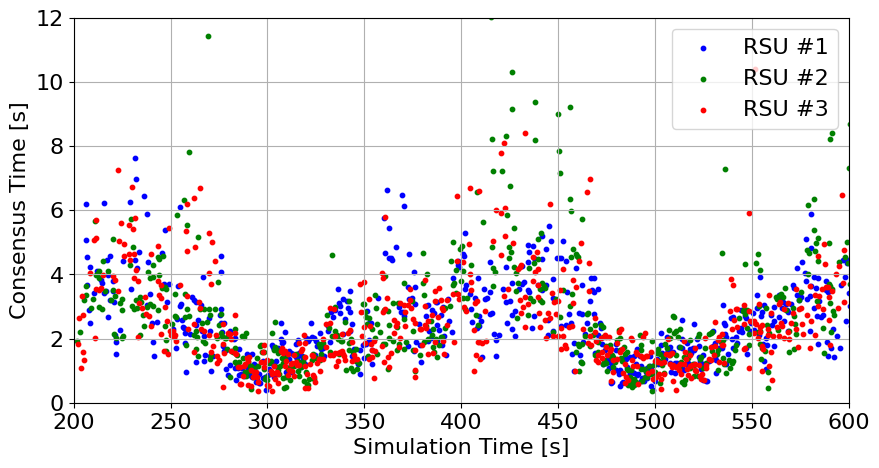


論文にかいた結果　一番近いrsuに割り当てたもの
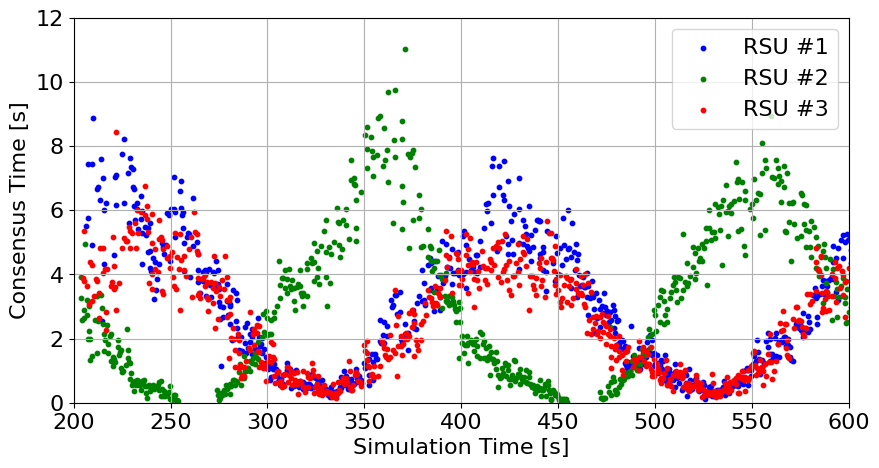

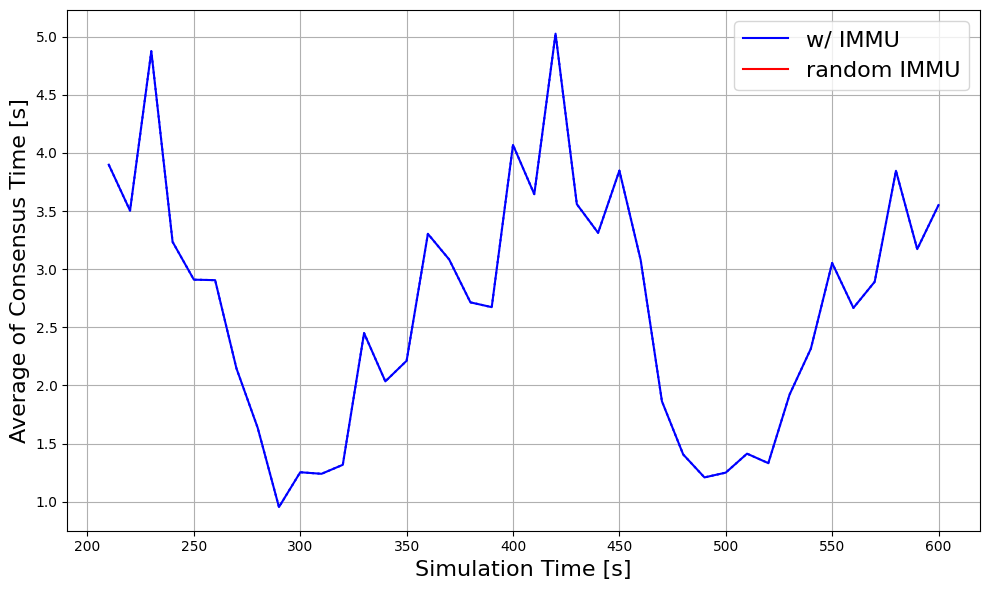

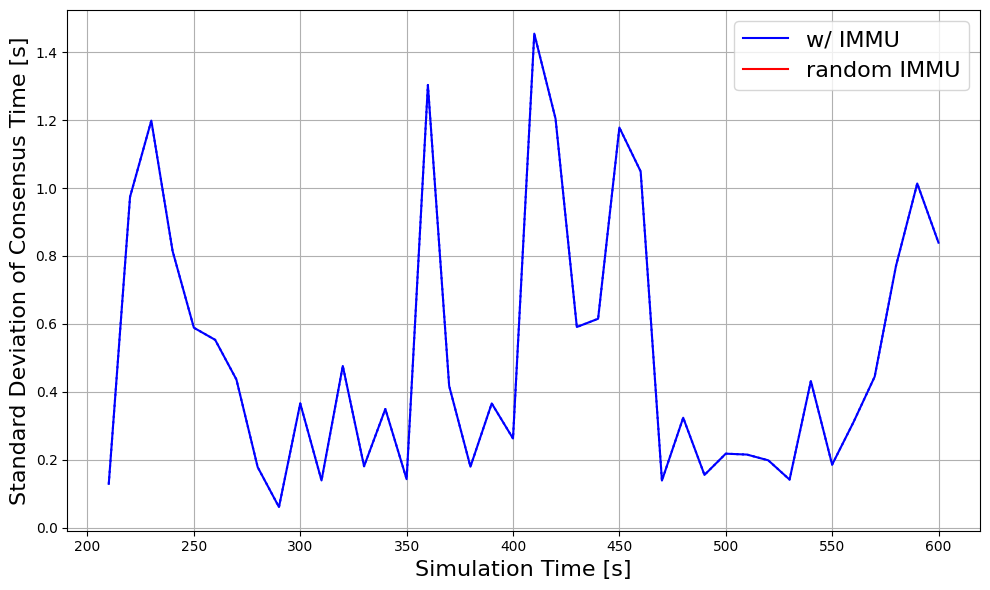

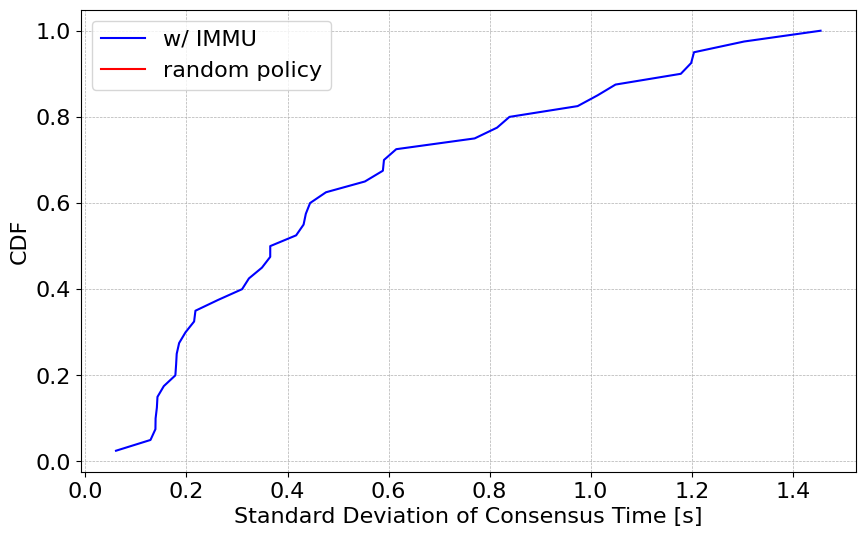

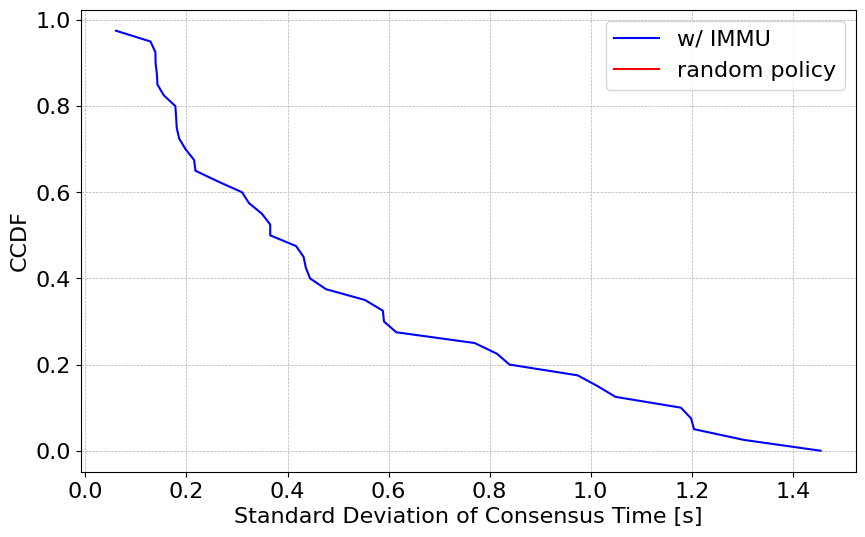

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def get_consensus_time(input_folder_path):
    # CSVファイルの読み込み
    proposer_df = pd.read_csv(input_folder_path + "consensus_folder.csv")
    proposer_df = proposer_df.replace('null', pd.NA)

    # 結果を格納するリスト
    simulation_buffer_time = 200
    simulation_start_time = 0
    simulation_time_list = []
    simulation_consensus_time_list = []

    # idごとに処理を行う
    for index, row in proposer_df.iterrows():
        if index == 0:
            simulation_start_time = int(row["start_time"])

        if pd.isna(row["end_time"]) or pd.isna(row["duration"]):
            continue  # Skip rows with NaN values
        
        simulation_now_time = (int(row["end_time"]) - simulation_start_time) / 1000 + simulation_buffer_time

        simulation_time_list.append(simulation_now_time)
        simulation_consensus_time_list.append(int(row["duration"]) / 1000)
    
    return simulation_time_list, simulation_consensus_time_list


def get_cdf_ccdf(data):
    # 有効なデータのみ取得（nanを除去）
    data = np.array(data)
    data = data[~np.isnan(data)]
    
    # CDFの計算
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # CCDFの計算 (1 - CDF)
    ccdf = 1 - cdf
    
    return sorted_data, cdf, ccdf


# vehicle_speed_list = [40, 50, 60, 70, 80]
vehicle_speed = 70
min_vehicle_speed = 30
proposer_num = 3
validator_num = 250
participant_size = proposer_num + validator_num
message_size = 32
network_delay = 0
proposer_id_list = [0, 1, 2]

# 時間帯を10秒刻みで区切る
time_bins = np.arange(200, 601, 10)

# データを格納するためのリスト
averages_by_time_bin_1 = {proposer_id: [] for proposer_id in proposer_id_list}
averages_by_time_bin_2 = {proposer_id: [] for proposer_id in proposer_id_list}



# 各プロポーザーのstart_time_listとconsensus_time_listを取得
for proposer_id in proposer_id_list:
    # 1つ目のinput_folder_path
    input_folder_path_1 = "../../results/multi_rsu_congestion_with_immu/wd/vs70_30/n" + str(participant_size) + "/m" + str(message_size) + "/d" + str(network_delay) + "/" + str(proposer_id) + "/"
    start_time_list_1, consensus_time_list_1 = get_consensus_time(input_folder_path_1)

    # 2つ目のinput_folder_path
    input_folder_path_2 = "../../results/multi_rsu_congestion/vs70_30/n" + str(participant_size) + "/m" + str(message_size) + "/d" + str(network_delay) + "/" + str(proposer_id) + "/"
    start_time_list_2, consensus_time_list_2 = get_consensus_time(input_folder_path_2)

    # 10秒間隔での合意形成時間の平均を計算
    for time_bin in time_bins:
        consensus_times_in_bin_1 = []
        consensus_times_in_bin_2 = []

        # 1つ目のデータ
        for start_time, consensus_time in zip(start_time_list_1, consensus_time_list_1):
            if time_bin <= start_time < time_bin + 5:
                consensus_times_in_bin_1.append(consensus_time)
        
        # 2つ目のデータ
        for start_time, consensus_time in zip(start_time_list_2, consensus_time_list_2):
            if time_bin <= start_time < time_bin + 5:
                consensus_times_in_bin_2.append(consensus_time)

        # 平均をリストに追加
        if consensus_times_in_bin_1:
            averages_by_time_bin_1[proposer_id].append(np.mean(consensus_times_in_bin_1))
        else:
            averages_by_time_bin_1[proposer_id].append(np.nan)

        if consensus_times_in_bin_2:
            averages_by_time_bin_2[proposer_id].append(np.mean(consensus_times_in_bin_2))
        else:
            averages_by_time_bin_2[proposer_id].append(np.nan)



# 合意形成時間の平均のグラフも出す
averages_by_time_list_bin_1 = []
averages_by_time_list_bin_2 = []

for index in range(len(averages_by_time_bin_1[0])):
    consensus_average_time = 0
    for proposer_id in proposer_id_list:
        if averages_by_time_bin_1[proposer_id][index]:
            consensus_average_time += averages_by_time_bin_1[proposer_id][index]
        else:
            consensus_average_time =-1000
    
    if consensus_average_time > 0:
        averages_by_time_list_bin_1.append(consensus_average_time / len(proposer_id_list))
    else:
        averages_by_time_list_bin_1.append(np.nan)

for index in range(len(averages_by_time_bin_2[0])):
    consensus_average_time = 0
    for proposer_id in proposer_id_list:
        if averages_by_time_bin_1[proposer_id][index]:
            consensus_average_time += averages_by_time_bin_2[proposer_id][index]
        else:
            consensus_average_time =-1000
    
    if consensus_average_time > 0:
        averages_by_time_list_bin_2.append(consensus_average_time / len(proposer_id_list))
    else:
        averages_by_time_list_bin_2.append(np.nan)


# 補完処理: nanを線形補完
averages_by_time_list_bin_1_interp = pd.Series(averages_by_time_list_bin_1).interpolate().to_numpy()
averages_by_time_list_bin_2_interp = pd.Series(averages_by_time_list_bin_2).interpolate().to_numpy()

# プロット
plt.figure(figsize=(10, 6))

# 補完されていない部分を点線で表示
plt.plot(time_bins, averages_by_time_list_bin_1, label="w/ IMMU", color='blue')
plt.plot(time_bins, averages_by_time_list_bin_2, label="random IMMU", color='red')

# 補完後の部分を実線で表示
plt.plot(time_bins, averages_by_time_list_bin_1_interp, color='blue',  linestyle='dotted')
plt.plot(time_bins, averages_by_time_list_bin_2_interp, color='red',  linestyle='dotted')

plt.xlabel("Simulation Time [s]", fontsize=16)
plt.ylabel("Average of Consensus Time [s]", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)

plt.tight_layout()
plt.show()


# proposer間の平均時間の標準偏差を算出
std_devs_by_time_bin_1 = []
std_devs_by_time_bin_2 = []

for i in range(len(time_bins)):
    # 1つ目のinput_folder_pathに基づく平均の標準偏差を計算
    time_bin_averages_1 = []
    for proposer_id in proposer_id_list:
        time_bin_averages_1.append(averages_by_time_bin_1[proposer_id][i])
    std_devs_by_time_bin_1.append(np.std(time_bin_averages_1))

    # 2つ目のinput_folder_pathに基づく平均の標準偏差を計算
    time_bin_averages_2 = []
    for proposer_id in proposer_id_list:
        time_bin_averages_2.append(averages_by_time_bin_2[proposer_id][i])
    std_devs_by_time_bin_2.append(np.std(time_bin_averages_2))

# 補完処理: nanを線形補完
std_devs_by_time_bin_1_interp = pd.Series(std_devs_by_time_bin_1).interpolate().to_numpy()
std_devs_by_time_bin_2_interp = pd.Series(std_devs_by_time_bin_2).interpolate().to_numpy()

# プロット
plt.figure(figsize=(10, 6))

# 補完されていない部分を点線で表示
plt.plot(time_bins, std_devs_by_time_bin_1, label="w/ IMMU", color='blue')
plt.plot(time_bins, std_devs_by_time_bin_2, label="random IMMU", color='red')

# 補完後の部分を実線で表示
plt.plot(time_bins, std_devs_by_time_bin_1_interp, color='blue',  linestyle='dotted')
plt.plot(time_bins, std_devs_by_time_bin_2_interp, color='red',  linestyle='dotted')

plt.xlabel("Simulation Time [s]", fontsize=16)
plt.ylabel("Standard Deviation of Consensus Time [s]", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)

plt.tight_layout()
plt.show()




# CDFとCCDFの計算
sorted_data_1, cdf_1, ccdf_1 = get_cdf_ccdf(std_devs_by_time_bin_1)
sorted_data_2, cdf_2, ccdf_2 = get_cdf_ccdf(std_devs_by_time_bin_2)

# CDFのプロット
plt.figure(figsize=(10, 6))
# 縦軸を対数スケールに設定

plt.plot(sorted_data_1, cdf_1, label="w/ IMMU", color='blue')
plt.plot(sorted_data_2, cdf_2, label="random policy", color='red')
plt.xlabel("Standard Deviation of Consensus Time [s]", fontsize=16)
plt.ylabel("CDF", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # 対数スケールで両方の目盛り線を表示
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# CCDFのプロット
plt.figure(figsize=(10, 6))
# 縦軸を対数スケールに設定

plt.plot(sorted_data_1, ccdf_1, label="w/ IMMU", color='blue')
plt.plot(sorted_data_2, ccdf_2, label="random policy", color='red')
plt.xlabel("Standard Deviation of Consensus Time [s]", fontsize=16)
plt.ylabel("CCDF", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # 対数スケールで両方の目盛り線を表示
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


論文にかいた結果　一番近いrsuに割り当てたもの

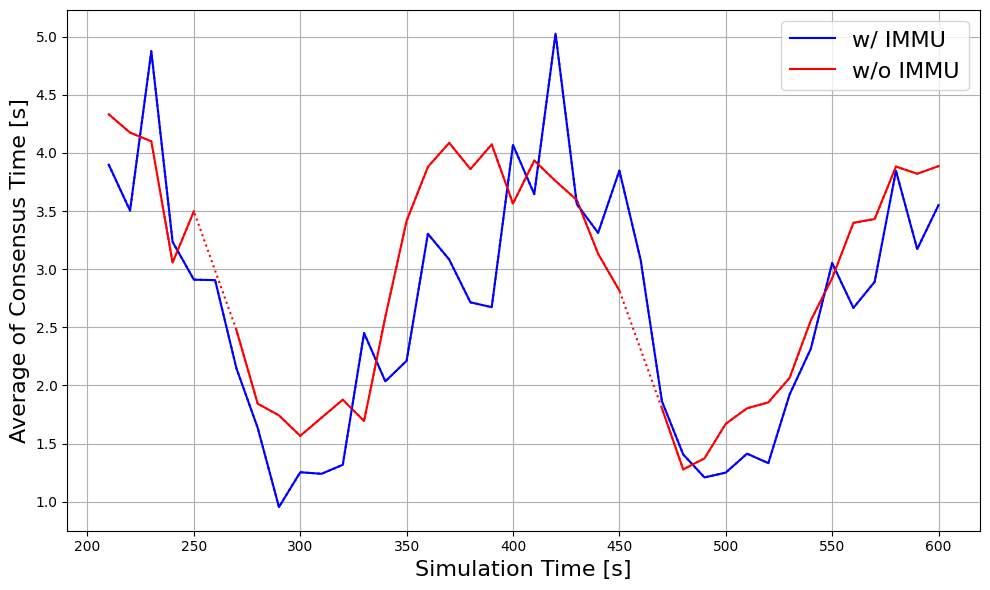
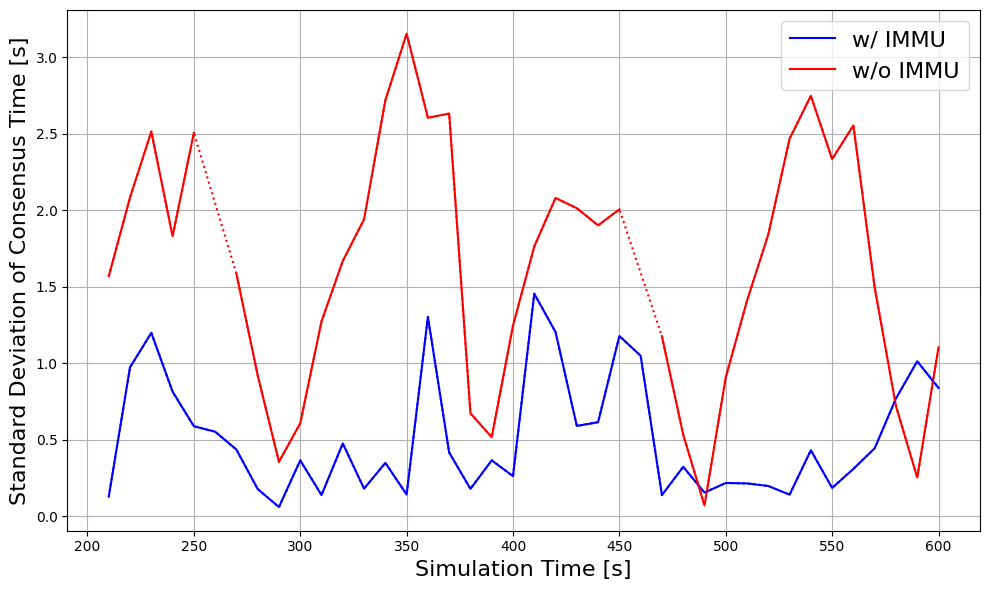
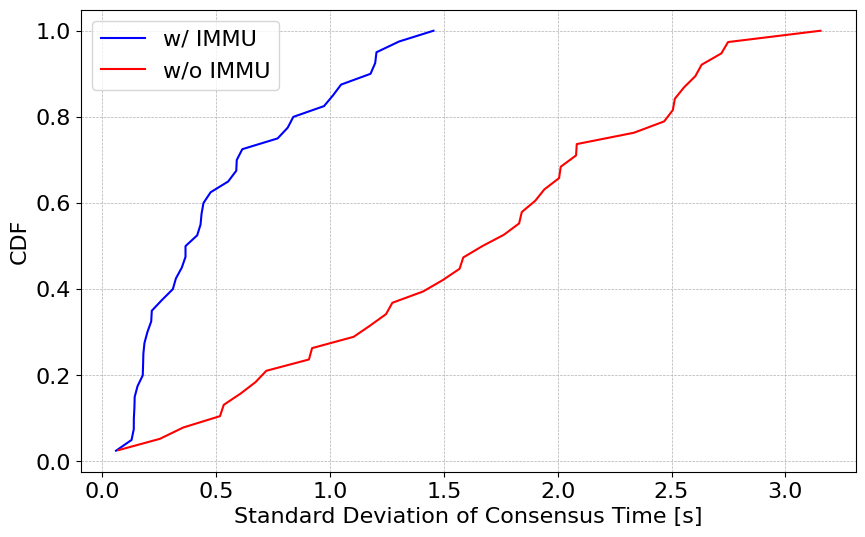
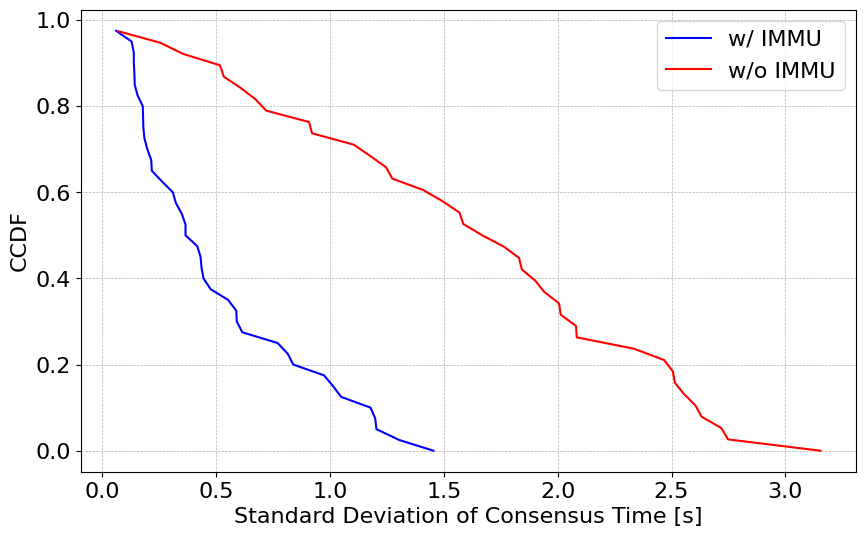

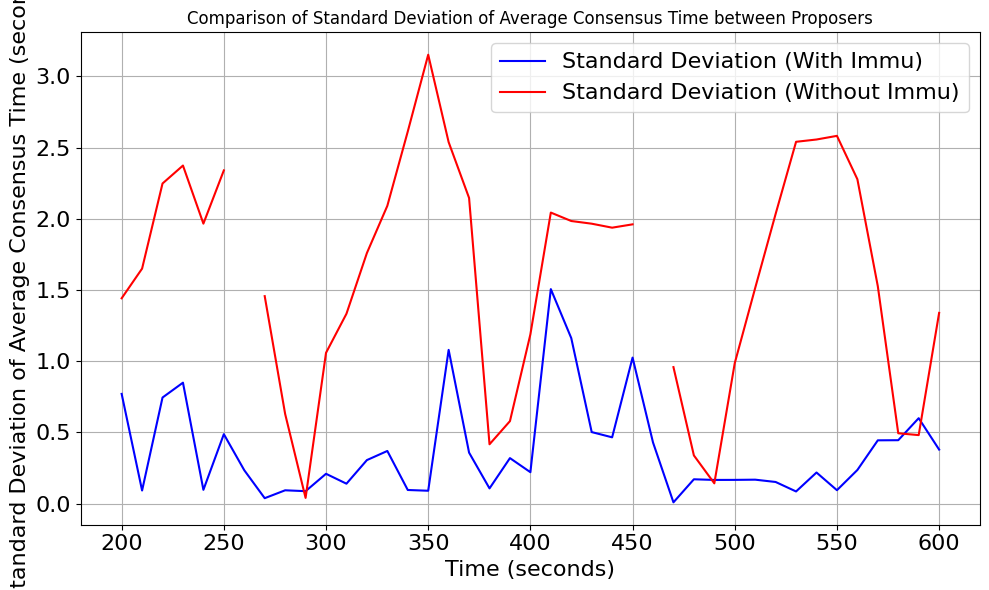